## Implementing Diffusion Models

In [2]:
import os
# Suppress oneDNN optimizations and lower TensorFlow logging level
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Load the data set  
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize the pixel values  
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Expand dimensions to match the input shape (28, 28, 1)  
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Add noise to the data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip the values to be within the range [0, 1]
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [3]:
# Define the diffusion model architecture with reduced complexity
input_layer = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)  # Reduced filters
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Flatten()(x)
x = Dense(64, activation='relu')(x)  # Reduced size
x = Dense(28*28*32, activation='relu')(x)  # Reduced size
x = Reshape((28, 28, 32))(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)  # Reduced filters
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
diffusion_model = Model(input_layer, output_layer)

# Compile the model with mixed precision and a different loss function
diffusion_model.compile(optimizer='adam', loss='mean_squared_error')  # Using MSE for regression tasks

# Summary of the optimized model
diffusion_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25088)          │     1,630,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         4,624 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,233 (12.42 MB)

 Trainable params: 3,255,233 (12.42 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# Cache and prefetch the data using TensorFlow data pipelines for faster loading
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
train_dataset = train_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test))
val_dataset = val_dataset.cache().batch(64).prefetch(tf.data.AUTOTUNE)  # Reduced batch size

In [5]:
# Implement early stopping based on validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model with early stopping and smaller batch size
diffusion_model.fit(
    train_dataset,
    epochs=3,
    shuffle=True,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 95s 99ms/step - loss: 0.0745 - val_loss: 0.0498
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 103ms/step - loss: 0.0415 - val_loss: 0.0310
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 98s 104ms/step - loss: 0.0287 - val_loss: 0.0279


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step


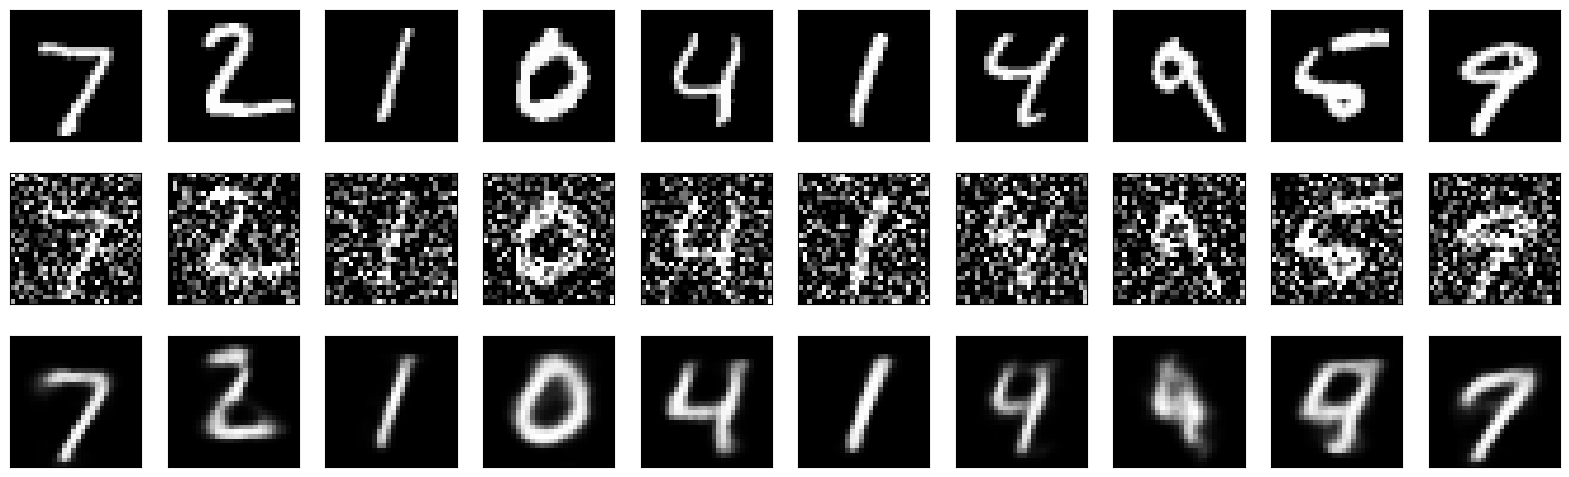

In [6]:
import matplotlib.pyplot as plt

# Predict the denoised images
denoised_images = diffusion_model.predict(x_test_noisy)

# Visualize the results
n = 10  # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display denoised
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [7]:
# Unfreeze the top layers of the model
for layer in diffusion_model.layers[-4:]:
    layer.trainable = True

# Compile the model again
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the model again
diffusion_model.fit(x_train_noisy, x_train,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_data=(x_test_noisy, x_test))

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 110s 116ms/step - loss: 0.1433 - val_loss: 0.1404
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 126s 134ms/step - loss: 0.1392 - val_loss: 0.1386
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 126s 134ms/step - loss: 0.1368 - val_loss: 0.1376
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 109s 116ms/step - loss: 0.1347 - val_loss: 0.1376
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 114s 121ms/step - loss: 0.1338 - val_loss: 0.1366
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 102s 108ms/step - loss: 0.1326 - val_loss: 0.1368
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 122s 129ms/step - loss: 0.1312 - val_loss: 0.1367
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 97s 103ms/step - loss: 0.1309 - val_loss: 0.1366
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 121s 129ms/step - loss: 0.1301 - val_loss: 0.1370
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 108s 115ms/step - loss: 0.1294 - val_loss: 0.1376


#### Modify the noise factor

1. Change the noise factor to 0.3.  
2. Add noise to the training and test data sets with the new noise factor.  
3. Retrain the model with the new noisy data.

In [9]:
# Modify the noise factor to 0.3  
noise_factor = 0.3

# Add noise to the data with the new noise factor  
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

# Clip the values to be within the range [0, 1]  
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Retrain the model  
diffusion_model.fit(x_train_noisy, x_train,epochs=50,batch_size=128,shuffle=True,validation_data=(x_test_noisy, x_test))

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 83s 178ms/step - loss: 0.1241 - val_loss: 0.1192
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 85s 181ms/step - loss: 0.1186 - val_loss: 0.1181
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 78s 166ms/step - loss: 0.1177 - val_loss: 0.1173
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 79s 169ms/step - loss: 0.1168 - val_loss: 0.1166
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 74s 158ms/step - loss: 0.1156 - val_loss: 0.1163
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - loss: 0.1154 - val_loss: 0.1161
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - loss: 0.1144 - val_loss: 0.1157
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - loss: 0.1140 - val_loss: 0.1156
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 156ms/step - loss: 0.1134 - val_loss: 0.1154
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 73s 155ms/step - loss: 0.1128 - val_loss: 0.1149
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 72s 154ms/step - loss: 0.1125 - val_loss: 0.1150
Epoch 12/50
469/469

#### Add more layers to the model

1. Add an additional Conv2D layer with 128 filters in the encoder.  
2. Add an additional Conv2DTranspose layer with 128 filters in the decoder.  
3. Rebuild, compile, and train the model.

In [4]:
# Define the modified diffusion model architecture with additional layers
input_layer = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(28*28*64, activation='relu')(x)
x = Reshape((28, 28, 64))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x) # Additional layer
x = Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

diffusion_model = Model(input_layer, output_layer)

# Compile the model  
diffusion_model.compile(optimizer='adam', loss='binary_crossentropy')

# Summary of the model  
diffusion_model.summary()

# Train the model  
diffusion_model.fit(x_train_noisy, x_train,epochs=50, batch_size=128,shuffle=True, validation_data=(x_test_noisy, x_test))

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50176)          │     6,472,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 28, 28, 128)    │        73,856 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,576,961 (74.68 MB)

 Trainable params: 19,576,961 (74.68 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 463s 985ms/step - loss: 0.2769 - val_loss: 0.1417
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 452s 963ms/step - loss: 0.1341 - val_loss: 0.1264
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 454s 968ms/step - loss: 0.1248 - val_loss: 0.1233
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 470s 1s/step - loss: 0.1203 - val_loss: 0.1187
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 454s 969ms/step - loss: 0.1168 - val_loss: 0.1187
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 442s 943ms/step - loss: 0.1140 - val_loss: 0.1175
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 440s 937ms/step - loss: 0.1112 - val_loss: 0.1175
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 437s 932ms/step - loss: 0.1093 - val_loss: 0.1178
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 437s 931ms/step - loss: 0.1067 - val_loss: 0.1212
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 460s 981ms/step - loss: 0.1049 - val_loss: 0.1194
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 465s 991ms/step - loss: 0.1034 - val_loss: 0.1215
Epoch 12/50

#### Visualize the effect of noise

1. Add noise with different factors (e.g., 0.1, 0.5, 0.7) to the test data.  
2. Use the model to predict the denoised images for each noise level.  
3. Visualize the original, noisy, and denoised images side by side for each noise level.


313/313 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 103ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step


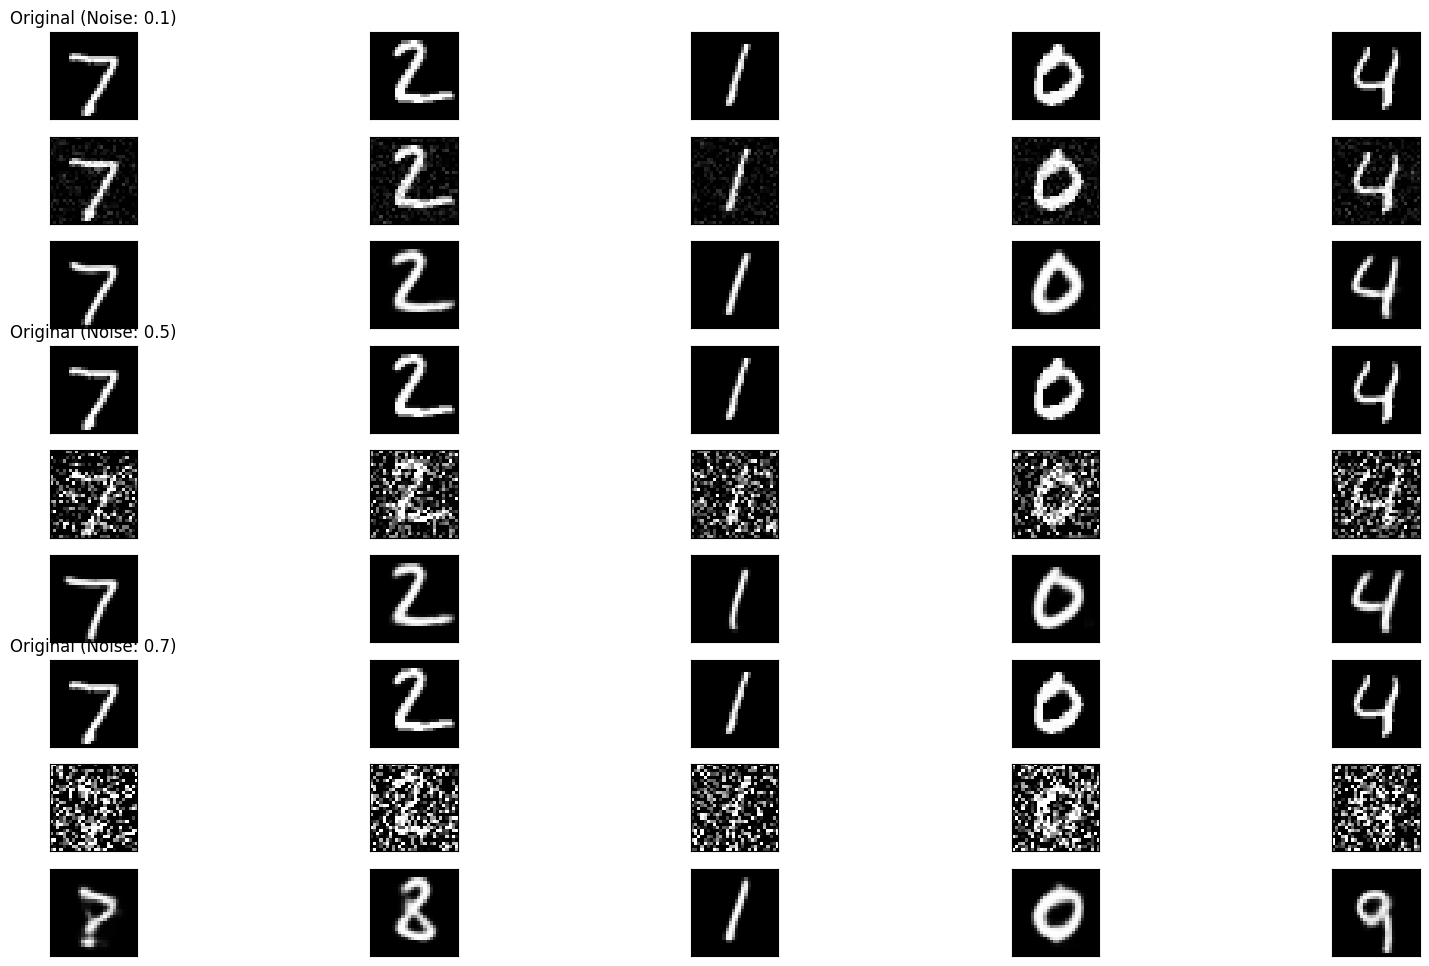

In [5]:
import matplotlib.pyplot as plt

# Function to add noise and predict denoised images
def add_noise_and_predict(noise_factor):
    x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
    x_test_noisy = np.clip(x_test_noisy, 0., 1.)
    denoised_images = diffusion_model.predict(x_test_noisy)
    return x_test_noisy, denoised_images

# Noise levels to test
noise_levels = [0.1, 0.5, 0.7]

# Visualize the results
n = 5 # Number of digits to display
plt.figure(figsize=(20, 12))
for idx, noise_factor in enumerate(noise_levels):
    x_test_noisy, denoised_images = add_noise_and_predict(noise_factor)

    for i in range(n):
        # Display original
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + idx * 3 * n)
        plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False) 

        if i == 0:
            ax.set_title(f'Original (Noise: {noise_factor})')

        # Display noisy
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + n + idx * 3 * n)
        plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False) 


        # Display denoised
        ax = plt.subplot(3 * len(noise_levels), n, i + 1 + 2 * n + idx * 3 * n)
        plt.imshow(denoised_images[i].reshape(28, 28), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()